In [9]:
#importing required libraries
import torch
import numpy as np
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [10]:

#setting random seed
np.random.seed(2710)
torch.manual_seed(100)

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]


"""Parameters"""

# Number of samples per batch to load
batch_size = 100

# Percentage of training set to use for validation
valid_size = 0.2

# Number of classes
num_classes = 3

# Number of epochs
num_epochs = 10

# Optimizer function
opt_func = torch.optim.Adam

# Learning rate
lr = 0.001

In [11]:

# Check if CUDA is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [12]:
def plot_losses(train_history, val_history):
    '''Function to plot loss curves'''
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

In [13]:
def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer


In [14]:
"""Load the data"""

def load_dataset(typeOfData='raw'):

    traindata_path = 'Data/train/'
    testdata_path = 'Data/test/'

    if (typeOfData=='greyscale'):
        # to convert images to greyscale images
        trainfull_dataset = torchvision.datasets.ImageFolder(
                root=traindata_path,
                transform=torchvision.transforms.Compose([
                torchvision.transforms.Grayscale(num_output_channels=1),torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor()]))

        print("Print here :",trainfull_dataset[0][0].size)
        #<built-in method size of Tensor object at 0x1c2fce0708>
        print(trainfull_dataset[0][0].shape)

        test_dataset = torchvision.datasets.ImageFolder(
            root=testdata_path,
            transform=torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=1),torchvision.transforms.Resize((32,32)),
            torchvision.transforms.ToTensor()]))
    elif(typeOfData=='raw'):
        # to convert images to raw (all 3 channels) images
        trainfull_dataset = torchvision.datasets.ImageFolder(
                root=traindata_path,
                transform=torchvision.transforms.Compose([torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor()]))

        test_dataset = torchvision.datasets.ImageFolder(
            root=testdata_path,
            transform=torchvision.transforms.Compose([torchvision.transforms.Resize((32,32)),
            torchvision.transforms.ToTensor()]))

    #train and test split in 80 20 ratio
    train_size = int(0.8 * len(trainfull_dataset))
    test_size = len(trainfull_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(trainfull_dataset, [train_size, test_size])

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size,
        shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size,
        shuffle=True
    )


    return train_loader, val_loader,test_loader

In [15]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self,typeOfData='raw'):
        super(SimpleConvolutionalNetwork, self).__init__()
        self.typeOfData=typeOfData

        print(self.typeOfData)
        if (self.typeOfData=='raw'):
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        elif(self.typeOfData=='greyscale'):
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        #self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)

        self.fc1 = nn.Linear(32 * 16 * 16, 64)

        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32 (Recall: (N -F+2P)/S+1) = (32-3+2*1)/1+1=32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16 (Recall: (N -F+2P)/S+1) = (32-2+2*0)/2+1 = 16
        # x = self.pool(x)
        # 18x32x32 -> 18x16x16 (Recall: (N -F+2P)/S+1) = (32-2+2*0)/2+1 = 16
        #x = F.relu(self.conv2(x))
        # # 18x16x16 -> 18x8x8 (Recall: (N -F+2P)/S+1) = (16-2+2*0)/2+1 = 8
        x = self.pool(x)



        x = x.view(-1, 32 * 16 * 16)
        # 32 * 16 * 16 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 3
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x


    def train(net, batch_size, n_epochs, learning_rate,typeOfData):
        """
        Train a neural network and print statistics of the training

        :param net: (PyTorch Neural Network)
        :param batch_size: (int)
        :param n_epochs: (int)  Number of iterations on the training set
        :param learning_rate: (float) learning rate used by the optimizer
        """
        print("===== HYPERPARAMETERS =====")
        print("batch_size=", batch_size)
        print("n_epochs=", n_epochs)
        print("learning_rate=", learning_rate)
        print("=" * 30)

        train_loader, val_loader, test_loader = load_dataset(typeOfData=typeOfData)
        n_minibatches = len(train_loader)

        criterion, optimizer = createLossAndOptimizer(net, learning_rate)
        # Init variables used for plotting the loss
        train_history = []
        val_history = []

        training_start_time = time.time()
        best_error = np.inf
        best_model_path = "best_model.pth"

        # Move model to gpu if possible
        net = net.to(device)

        for epoch in range(n_epochs):  # loop over the dataset multiple times

            running_loss = 0.0
            print_every = n_minibatches // 10
            start_time = time.time()
            total_train_loss = 0

            for i, (inputs, labels) in enumerate(train_loader):

                # Move tensors to correct device
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                total_train_loss += loss.item()

                # print every 10th of epoch
                if (i + 1) % (print_every + 1) == 0:
                    print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                          epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                          time.time() - start_time))
                    running_loss = 0.0
                    start_time = time.time()

            train_history.append(total_train_loss / len(train_loader))

            total_val_loss = 0
            # Do a pass on the validation set
            # We don't need to compute gradient,
            # we save memory and computation using torch.no_grad()
            with torch.no_grad():
              for inputs, labels in val_loader:
                  # Move tensors to correct device
                  inputs, labels = inputs.to(device), labels.to(device)
                  # Forward pass
                  predictions = net(inputs)
                  val_loss = criterion(predictions, labels)
                  total_val_loss += val_loss.item()

            val_history.append(total_val_loss / len(val_loader))
            # Save model that performs best on validation set
            if total_val_loss < best_error:
                best_error = total_val_loss
                torch.save(net.state_dict(), best_model_path)

            print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

        print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))

        # Load best model
        net.load_state_dict(torch.load(best_model_path))

        return train_history, val_history


In [16]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))



def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")

def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)

Please enter Type of Data
 1. 3 channel image 	 2. Greyscale image :1
raw
===== HYPERPARAMETERS =====
batch_size= 100
n_epochs= 10
learning_rate= 0.001
Epoch 1, 11% 	 train_loss: 1.13 took: 60.82s
Epoch 1, 23% 	 train_loss: 1.00 took: 59.98s
Epoch 1, 35% 	 train_loss: 0.96 took: 122.47s
Epoch 1, 47% 	 train_loss: 0.83 took: 103.94s
Epoch 1, 59% 	 train_loss: 0.80 took: 76.14s
Epoch 1, 71% 	 train_loss: 0.66 took: 27.22s
Epoch 1, 83% 	 train_loss: 0.55 took: 38.36s
Epoch 1, 95% 	 train_loss: 0.49 took: 71.15s
Validation loss = 0.38
Epoch 2, 11% 	 train_loss: 0.45 took: 55.65s
Epoch 2, 23% 	 train_loss: 0.45 took: 52.32s
Epoch 2, 35% 	 train_loss: 0.40 took: 66.98s
Epoch 2, 47% 	 train_loss: 0.40 took: 52.06s
Epoch 2, 59% 	 train_loss: 0.33 took: 58.98s
Epoch 2, 71% 	 train_loss: 0.36 took: 65.97s
Epoch 2, 83% 	 train_loss: 0.44 took: 54.40s
Epoch 2, 95% 	 train_loss: 0.40 took: 54.50s
Validation loss = 0.31
Epoch 3, 11% 	 train_loss: 0.37 took: 59.45s
Epoch 3, 23% 	 train_loss: 0.36 too

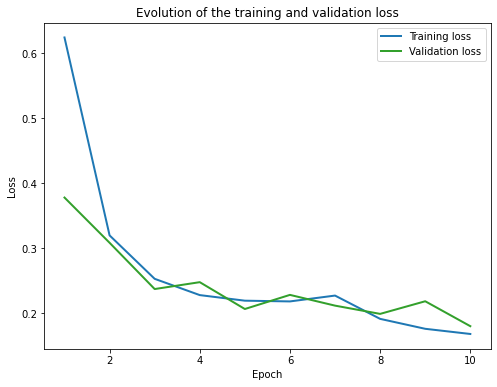

Computing accuracy...


KeyboardInterrupt: 

In [17]:
choice=input("Please enter Type of Data\n 1. 3 channel image \t 2. Greyscale image :")

if choice=='1':
    typeOfData='raw'
else:
    typeOfData='greyscale'

net = SimpleConvolutionalNetwork(typeOfData=typeOfData)

train_history, val_history = net.train( batch_size=100, n_epochs=10, learning_rate=0.001,typeOfData=typeOfData)

plot_losses(train_history, val_history)

train_loader, val_loader, test_loader = load_dataset(typeOfData=typeOfData)


In [18]:

print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 4115 train images: 94.14 %
Accuracy of the network on the 1029 validation images: 95.34 %
Accuracy of the network on the 1288 test images: 94.41 %


Please enter Type of Data
 1. 3 channel image 	 2. Greyscale image :2
greyscale
===== HYPERPARAMETERS =====
batch_size= 100
n_epochs= 10
learning_rate= 0.001
Print here : <built-in method size of Tensor object at 0x7fbacd22c780>
torch.Size([1, 32, 32])
Epoch 1, 11% 	 train_loss: 1.20 took: 29.93s
Epoch 1, 23% 	 train_loss: 0.97 took: 31.97s
Epoch 1, 35% 	 train_loss: 0.93 took: 31.01s
Epoch 1, 47% 	 train_loss: 0.84 took: 27.97s
Epoch 1, 59% 	 train_loss: 0.74 took: 33.64s
Epoch 1, 71% 	 train_loss: 0.68 took: 23.14s
Epoch 1, 83% 	 train_loss: 0.59 took: 28.82s
Epoch 1, 95% 	 train_loss: 0.56 took: 23.93s
Validation loss = 0.42
Epoch 2, 11% 	 train_loss: 0.53 took: 27.65s
Epoch 2, 23% 	 train_loss: 0.46 took: 32.30s
Epoch 2, 35% 	 train_loss: 0.42 took: 27.98s
Epoch 2, 47% 	 train_loss: 0.45 took: 34.10s
Epoch 2, 59% 	 train_loss: 0.43 took: 35.36s
Epoch 2, 71% 	 train_loss: 0.41 took: 25.61s
Epoch 2, 83% 	 train_loss: 0.34 took: 33.39s
Epoch 2, 95% 	 train_loss: 0.36 took: 51.74s
Vali

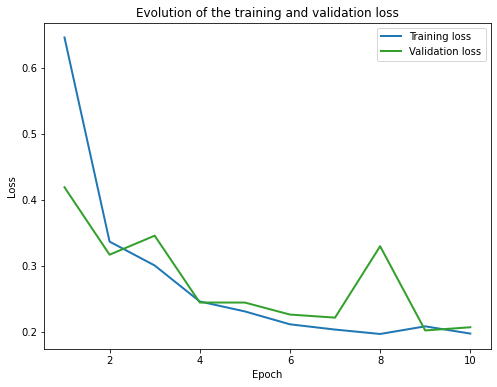

Print here : <built-in method size of Tensor object at 0x7fbaa7a32080>
torch.Size([1, 32, 32])
Computing accuracy...
Accuracy of the network on the 4115 train images: 93.22 %
Accuracy of the network on the 1029 validation images: 93.68 %
Accuracy of the network on the 1288 test images: 94.64 %


In [19]:
choice=input("Please enter Type of Data\n 1. 3 channel image \t 2. Greyscale image :")

if choice=='1':
    typeOfData='raw'
else:
    typeOfData='greyscale'

net = SimpleConvolutionalNetwork(typeOfData=typeOfData)

train_history, val_history = net.train( batch_size=100, n_epochs=10, learning_rate=0.001,typeOfData=typeOfData)

plot_losses(train_history, val_history)

train_loader, val_loader, test_loader = load_dataset(typeOfData=typeOfData)

print("Computing accuracy...")
compute_accuracy(net)